<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


# Dataset

Utilizaremos un corpues compuesto por obras de Jorge Luis Borges

In [2]:
# Para TensorFlow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-04-19 13:22:10.679170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745079730.701679    5789 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745079730.708799    5789 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745079730.726253    5789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745079730.726279    5789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745079730.726281    5789 computation_placer.cc:177] computation placer alr

[]


W0000 00:00:1745079736.165523    5789 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
import random
import io
import pickle
import lxml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [4]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('full_corpus.csv', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/karen-pal/borges/refs/heads/master/datasets/full_corpus.csv -o full_corpus.csv
        else:
            !wget gull_corpus.csv https://raw.githubusercontent.com/karen-pal/borges/refs/heads/master/datasets/full_corpus.csv

else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [6]:
# Nos quedamos unicamente 30 obras de Borges. Nota: se seleccionaron 30 unicamente por inconvenientes de RAM a la hora de entrenar los modelos

df = pd.read_csv('full_corpus.csv').drop(columns=["Unnamed: 0"])
df_borges = df[df.author == 'Jorge Luis Borges'][:30]
print(f'Cantidad de documentos: {df_borges.shape[0]}')
df_borges

Cantidad de documentos: 30


,link,text,title,metadata,author
144,https://ciudadseva.com/texto/abel-y-cain-borges/,Abel y Caín se encontraron después de la muert...,Abel y Caín,[Minicuento - Texto completo.],Jorge Luis Borges
145,https://ciudadseva.com/texto/adrogue/,"Era muy lindo, un pueblo laberíntico. A veces,...",Adrogué,[Minicuento - Texto completo.],Jorge Luis Borges
146,https://ciudadseva.com/texto/alguien-sonara/,¿Qué soñará el indescifrable futuro? Soñará qu...,Alguien soñará,[Minicuento - Texto completo.],Jorge Luis Borges
147,https://ciudadseva.com/texto/andres-armoa/,Los años le han dejado unas palabras en guaran...,Andrés Armoa,[Minicuento - Texto completo.],Jorge Luis Borges
148,https://ciudadseva.com/texto/argumentum-ornith...,Cierro los ojos y veo una bandada de pájaros. ...,Argumentum ornithologicum,[Minicuento - Texto completo.],Jorge Luis Borges
149,https://ciudadseva.com/texto/biografia-de-tade...,"El seis de febrero de 1829, los montoneros que...",Biografía de Tadeo Isidoro Cruz,(1829-1874),Jorge Luis Borges
150,https://ciudadseva.com/texto/biografia-de-tade...,"El seis de febrero de 1829, los montoneros que...",Biografía de Tadeo Isidoro Cruz,(1829-1874),Jorge Luis Borges
151,https://ciudadseva.com/texto/del-rigor-en-la-c...,"En aquel Imperio, el Arte de la Cartografía lo...",Del Rigor en la Ciencia,[Minicuento - Texto completo.],Jorge Luis Borges
152,https://ciudadseva.com/texto/dialogo-sobre-un-...,"A- Distraídos en razonar la inmortalidad, habí...",Diálogo sobre un diálogo,[Minicuento - Texto completo.],Jorge Luis Borges
153,https://ciudadseva.com/texto/el-acercamiento-a...,Philip Guedalla escribe que la novela The appr...,El acercamiento a Almotásim,[Cuento - Texto completo.],Jorge Luis Borges


In [8]:
# Concatenamos todas las obras de Borges y le eliminamos la palabra FIN, ya que la mayoría de las obras la tienen, con el fin de evitar relaciones impropias
article_text = ' '.join(df_borges['text'].astype(str))
article_text = article_text.replace('FIN', '')

# Guardamos el corpus concatenado

with open('obras_borges.csv', 'w', encoding='utf-8') as f:
    f.write(article_text)


### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [9]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [10]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [11]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

# pasar todo el texto a minúscula
article_text = article_text.lower()


In [12]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

100

In [13]:
chars_vocab

{' ',
 '!',
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '¡',
 '«',
 '²',
 '¹',
 '»',
 '¿',
 'Á',
 'É',
 'Í',
 'Ú',
 'á',
 'ä',
 'é',
 'ê',
 'ë',
 'í',
 'ñ',
 'ó',
 'ö',
 'ú',
 'ü',
 '–',
 '—',
 '’',
 '“',
 '”',
 '…'}

Se observan algunas caracteres que pueden resultar irrelevantes para nuestro caso de estio como: '\xad' ,'²', '³', '¹'.

In [14]:
# Eliminamos algunos caracteres que no son útiles y redefinimos chars_vocab
article_text = article_text.replace('\xad', '').replace('²', '').replace('³','').replace('¹', '')
chars_vocab = set(article_text)
print(len(chars_vocab))

68


In [15]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.

# Nota el diccionario char2idx se extrajo de una corrida previa y es necesario definirlo de manera hard-codeada para utilizar los modelos guardados
char2idx = {'e': 0,
 '8': 1,
 '5': 2,
 'c': 3,
 't': 4,
 'n': 5,
 '¿': 6,
 '¡': 7,
 'l': 8,
 '—': 9,
 'j': 10,
 ':': 11,
 'f': 12,
 'x': 13,
 'z': 14,
 'y': 15,
 'u': 16,
 'q': 17,
 '”': 18,
 '…': 19,
 'á': 20,
 'a': 21,
 'g': 22,
 '-': 23,
 'o': 24,
 ';': 25,
 '7': 26,
 '*': 27,
 '2': 28,
 'w': 29,
 '!': 30,
 'é': 31,
 'í': 32,
 'ú': 33,
 '(': 34,
 '4': 35,
 'ü': 36,
 '?': 37,
 '6': 38,
 '’': 39,
 ' ': 40,
 'ö': 41,
 'm': 42,
 'ê': 43,
 'b': 44,
 'i': 45,
 'ñ': 46,
 'v': 47,
 'k': 48,
 'r': 49,
 '.': 50,
 '1': 51,
 'p': 52,
 ')': 53,
 '3': 54,
 '9': 55,
 '0': 56,
 '«': 57,
 '–': 58,
 '»': 59,
 'ë': 60,
 'h': 61,
 's': 62,
 'ó': 63,
 ',': 64,
 'ä': 65,
 'd': 66,
 '“': 67}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [16]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

### Organizando y estructurando el dataset

In [17]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [18]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [19]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [20]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [21]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [23]:
X[0]

array([21, 44,  0,  8, 40, 15, 40,  3, 21, 32,  5, 40, 62,  0, 40,  0,  5,
        3, 24,  5,  4, 49, 21, 49, 24,  5, 40, 66,  0, 62, 52, 16, 31, 62,
       40, 66,  0, 40,  8, 21, 40, 42, 16,  0, 49,  4,  0, 40, 66,  0, 40,
       21, 44,  0,  8, 50, 40,  3, 21, 42, 45,  5, 21, 44, 21,  5, 40, 52,
       24, 49, 40,  0,  8, 40, 66,  0, 62, 45,  0, 49,  4, 24, 40, 15, 40,
       62,  0, 40, 49,  0,  3, 24,  5, 24,  3, 45,  0, 49, 24,  5])

In [24]:
y[0]

array([44,  0,  8, 40, 15, 40,  3, 21, 32,  5, 40, 62,  0, 40,  0,  5,  3,
       24,  5,  4, 49, 21, 49, 24,  5, 40, 66,  0, 62, 52, 16, 31, 62, 40,
       66,  0, 40,  8, 21, 40, 42, 16,  0, 49,  4,  0, 40, 66,  0, 40, 21,
       44,  0,  8, 50, 40,  3, 21, 42, 45,  5, 21, 44, 21,  5, 40, 52, 24,
       49, 40,  0,  8, 40, 66,  0, 62, 45,  0, 49,  4, 24, 40, 15, 40, 62,
        0, 40, 49,  0,  3, 24,  5, 24,  3, 45,  0, 49, 24,  5, 40])

# Definiendo los modelos

In [25]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [26]:

class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5, name_model="my_model.keras"):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.history_ppl = history_ppl
      self.patience = patience
      self.name_model = name_model

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        print(self.name_model)
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.name_model)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [27]:
# Definimos para todos los modelos el vocab_size como la cantidad de caracteres permitidos

vocab_size = len(chars_vocab)

model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/home/nacho/.local/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        53,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 68)       │        13,668 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,468 (263.55 KB)

 Trainable params: 67,468 (263.55 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5, name_model="srnn.keras")], batch_size=256)

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.5425srnn.keras

 mean perplexity: 8.269874717443043 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - loss: 2.5423
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0750srnn.keras

 mean perplexity: 7.378323554992676 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 2.0749
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9580srnn.keras

 mean perplexity: 6.933388296884435 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 1.9579
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8954srnn.keras

 mean perplexity: 6.865189506352403 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 1.8954
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8576srnn.keras

 mean perplexity: 6.642576873757457 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 1.8576
Epoch 6/20
924/925 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)


plt.show()

Resultados:
- Épocas: 20
- Perplexity final media: 6.14

_Nota: el siguiente gráfico se obtuvo de un entrenamiento previo del modelo que no se muestra en los logs por falta de recursos de GPU de colab_


Se observa una mejora en el modelo a medida que aumentan las épocas. En la época 5 se observa un cambio de desaceleración de mejora en la "Perplexity", y se alcanza un valor asíntotico de 6 en las épocas finales.

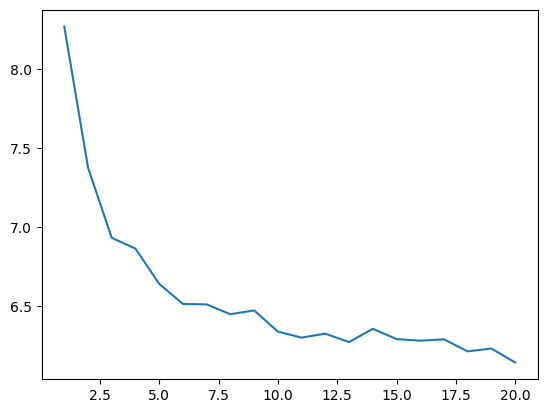



In [28]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_srnn = keras.models.load_model('srnn.keras')

## GRU

Este modelo se presenta como una evolución del modelo básico recurrente (SRNN) para el problema de "Long Short Term Memory", pero sin la misma perfomance que las redes LSTM, aunque sí, más sencillas y baratas.

In [29]:
from keras.layers import GRU

model_gru = Sequential()

model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 200)      │       162,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 68)       │        13,668 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,668 (686.20 KB)

 Trainable params: 175,668 (686.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_ppl = []
hist = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5, name_model="gru.keras")], batch_size=256)

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 2.6177gru.keras

 mean perplexity: 8.599032279644304 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 336s 354ms/step - loss: 2.6175
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 2.0566gru.keras

 mean perplexity: 7.501024678918242 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 380s 354ms/step - loss: 2.0566
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 1.8958gru.keras

 mean perplexity: 6.87974998832659 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 381s 352ms/step - loss: 1.8958
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 1.7816gru.keras

 mean perplexity: 6.499714834999492 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 366s 335ms/step - loss: 1.7815
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 1.7027gru.keras

 mean perplexity: 6.37394799894959 

Saved new model!
925/925 ━━━━━━━━━━━━━━━━━━━━ 309s 334ms/step - loss: 1.7027
Epoch 6/20
925/925 ━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)

Resultados:
- Épocas: 20
- Perplexity final media: 5.99

_Nota: el siguiente gráfico se obtuvo de un entrenamiento previo del modelo que no se muestra en los logs por falta de recursos de GPU de colab_


Al igual que en el SRNN, se observa una mejora en el modelo a medida que aumentan las épocas. En la época 5 se observa un cambio de desaceleración de mejora en la "Perplexity", y se alcanza un valor asíntotico de 6 en las épocas finales.

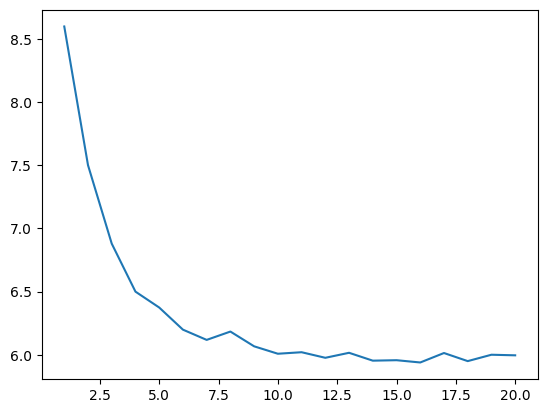

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_gru = keras.models.load_model('gru.keras')

## LSTM (Long Short Term Memory)

Este modelo presenta una solución forma al problema de "gradiente evanescente" propia de las RNN, en el cual se incorpora un estado de memoria de largo plazo y celdas que ponderan los términos más relevantes por medio de una entrada y salida propia de un catálogo de términos (C).

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()

model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 74)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       220,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 74)       │        14,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,874 (917.48 KB)

 Trainable params: 234,874 (917.48 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5, name_model="lstm.keras")], batch_size=256)

Resultados:
- Épocas: 20
- Perplexity final media: 5.99

_Nota: el siguiente gráfico se obtuvo de un entrenamiento previo del modelo que no se muestra en los logs por falta de recursos de GPU de colab_


Al igual que en el SRNN, se observa una mejora en el modelo a medida que aumentan las épocas. En la época 5 se observa un cambio de desaceleración de mejora en la "Perplexity", y se alcanza un valor asíntotico de 6 en las épocas finales.



In [30]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_lstm = keras.models.load_model('lstm.keras')

## SRNN con optimizador "Adam"

In [ ]:
vocab_size = len(chars_vocab)

model_adam = Sequential()

model_adam.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_adam.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_adam.add(Dense(vocab_size, activation='softmax'))
model_adam.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model_adam.summary()

In [ ]:
history_ppl = []
hist = model_adam.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5, name_model="srnn_adam.keras")], batch_size=256)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)

# Predicción del próximo caracter

In [33]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio
!pip install typing_extensions==4.7.1 --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
typing-inspection 0.4.0 requires typing-extensions>=4.12.0, but you have typing-extensions 4.7.1 which is incompatible.
pydantic 2.11.3 requires typing-extensions>=4.12.2, but you have typing-extensions 4.7.1 which is incompatible.
fastapi 0.115.12 requires typing-extensions>=4.8.0, but you have typing-extensions 4.7.1 which is incompatible.


In [ ]:
import gradio as gr

model = model_srnn # model_gru model_lstm

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

# Generación de secuencias

## Greedy search

In [35]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [58]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia

input_text='bioy comtemplaba a un perro salir por la puerta de vidrio'
print('='*40)
print(f'Input text: \"{input_text}\"')
model_names = ['srnn.keras','lstm.keras','gru.keras']
for model_name in model_names:
    print('=' * 40)
    print(f'Model: {model_name}')
    model = keras.models.load_model(model_name)
    output_text = generate_seq(model, input_text, max_length=max_context_size, n_words=40)
    print(f'Output text: {output_text}')

Input text: "bioy comtemplaba a un perro salir por la puerta de vidrio"
Model: srnn.keras
Output text: bioy comtemplaba a un perro salir por la puerta de vidrios en la casa de la casa de la casa de la
Model: lstm.keras
Output text: bioy comtemplaba a un perro salir por la puerta de vidrio de la cara de la cara de la cara de la 
Model: gru.keras
Output text: bioy comtemplaba a un perro salir por la puerta de vidrio de la cara de la cara de la cara de la 


La generación de texto por medio del modelo "Greedy Search", encuentra el siguiente caracter más probable para la secuencia de entrada. Esto genera, junto con la falta muestreo aleatorio con temperatura, la generación de loops repetitivos, tal como pueden observarse en los ejemplos anteriores. 

A su vez, se observa como los modelos GRU y LSTM tienen un comporamiento similar, ya que en ambos casos se utilizan estrategías para reducir el problema del gradiente evanescente.

###  Beam search y muestreo aleatorio



In [49]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [50]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [61]:
# predicción con beam search
input_text='bioy comtemplaba'
print('='*40)
print(f'Input text: \"{input_text}\"')
model_names = ['srnn.keras','lstm.keras','gru.keras']
temp_values = [1,10,100]
modes = ['det','sto']
for model_name in model_names:
    for temp in temp_values:
        for mode in modes:
            print('=' * 40)
            print(f'Model: {model_name}')
            print(f'Temp: {temp}')
            print(f'Mode: {mode}')
            model = keras.models.load_model(model_name)
            salidas = beam_search(model,num_beams=5,num_words=30,input=input_text,temp=temp,mode=mode)
            # veamos las salidas mas probables
            for idx,salida in enumerate(salidas):
                print(f'Output {idx+1}: {decode(salida)}')
        


Input text: "bioy comtemplaba"
Model: srnn.keras
Temp: 1
Mode: det
Output 1: bioy comtemplaba en un solo que el hombre de l
Output 2: bioy comtemplaba en un solo que el hombre de u
Output 3: bioy comtemplaba en un solo que el hombre. el 
Output 4: bioy comtemplaba en un solo que el hombre del 
Output 5: bioy comtemplaba en un solo que el hombre de a
Model: srnn.keras
Temp: 1
Mode: sto
Output 1: bioy comtemplaba en la erena de un indificarar
Output 2: bioy comtemplaba en la erena de un indificado 
Output 3: bioy comtemplaba en la erena de un indificara 
Output 4: bioy comtemplaba en la erena de un indificado,
Output 5: bioy comtemplaba en la erena de un indificara 
Model: srnn.keras
Temp: 10
Mode: det
Output 1: bioy comtemplaba en un solo que el hombre de l
Output 2: bioy comtemplaba en un solo que el hombre de u
Output 3: bioy comtemplaba en un solo que el hombre. el 
Output 4: bioy comtemplaba en un solo que el hombre del 
Output 5: bioy comtemplaba en un solo que el hombre de a
Model

# Conclusiones

Al comparar los resultados de los distintos modelos utilizando el método de predicción con "Beam Search", podemos extraer las siguientes conclusiones:
- Al comparar los modelos por separado, de manera deterministica, el modelo LSTM genera texto más coherente, gramatical y fluido. Lo que demuestra que la SRNN tiene menor capacidad para modelar dependencias largas que la LSTM
- Al incluir la temperatura en la predicción de resultados,ambos modelos estan infiriendo caracteres extremadamente improbables, lo que demuestra la gran dependencia que existe con la temperatura. Esto indica que las distribuciones de probabilidad deterministicas no se encuentra muy desbalanceadas entre sí, haciendolos muy sensibles a cualquier "ruido" estocástico.
- Si comparamos la complejidad de los modelos, la cantidad de parámetros entrenables, obseramos que la más sencilla es la SRNN con 70000 parametros aproximadamente, la GRU con 180000 parámetros aproximadamente (x2.6) y la LSTM con 225000 parámetros aproximadamente (x3.25), lo cual se relaciona con el resultado final, obteniendo frases más comprensibles con los últimos dos modelos en comparación con la primera. Sin embargo, los niveles de "perplexity" en todos los casos alcanzan valores similares, lo cual nos da a entender que analizar una red únicamente por medio de este parámetro es incompleto.